In [15]:
import pandas as pd
max_batch = 2
gpu_list = [1080, 2060]

ResNet = dict()
for i in range(1, max_batch + 1):
    for gpu in gpu_list:
        filename = f"Resnet/ResNet_{gpu}_{i}.csv"
        if not i in ResNet:
            ResNet[i] = dict()
        ResNet[i][gpu] = pd.read_csv(filename)['duration']
    

AlexNet = dict()
for i in range(1, max_batch + 1):
    for gpu in gpu_list:
        filename = f"AlexNet/ResNet_{gpu}_{i}.csv"
        if not i in AlexNet:
            AlexNet[i] = dict()
        AlexNet[i][gpu] = pd.read_csv(filename)['duration']

In [26]:
import torch
def get_children(model: torch.nn.Module):
    # get children form model
    children = list(model.children())
    flatt_children = []
    if children == []:
        # if model has no children; model is last child
        return model
    else:
        # look for children from children... to the last child
        for child in children:
            try:
                flatt_children.extend(get_children(child))
            except TypeError:
                flatt_children.append(get_children(child))
    return flatt_children

In [78]:
from torchvision.models import resnet18, vgg16, alexnet
model = alexnet()
children = get_children(model)
all_input_shape = list()

def make_forward(original_forward):
    def new_forward(x):
        all_input_shape.append(x.shape)
        out = original_forward(x)
        return out
    return new_forward
    
for layer in children:
    original_forward = layer.forward
    
    layer.forward = make_forward(original_forward)
    
data = torch.randn(1, 3, 224, 224)
result = model(data)

In [151]:
movement_time = list()
from time import sleep

for shape in all_input_shape:
    sleep(0.1)
    data = torch.randn(shape)
    data.to(0)
    with torch.autograd.profiler.profile(use_cuda=True) as prof:
        data.to(1)
    movement_time.append(round(prof.self_cpu_time_total * 1000))
movement_time.append(0)
print(movement_time)

[270453, 283650, 287305, 118770, 222906, 236775, 102075, 134500, 154716, 101985, 105358, 105028, 109224, 74777, 67946, 81469, 58170, 75397, 70838, 54422, 75510, 0]


In [166]:
fast, slow = 1080, 2060
for i in range(len(movement_time)-1):
    AlexNet_slow = sum(AlexNet[1][slow])
    AlexNet_fast = sum(AlexNet[1][fast])
    moved = sum(AlexNet[1][slow][:i]) + sum(AlexNet[1][fast][i:]) + movement_time[i]
    if AlexNet_slow - moved > 0:
        print("Move on layer will be faster", i)

Move on layer will be faster 3
Move on layer will be faster 6


In [133]:
fast, slow = 1080, 2060

delay = 0
ResNet_slow = (sum(ResNet[1][slow]))
ResNet_fast = sum(ResNet[1][fast])
AlexNet_slow = sum(AlexNet[1][slow])
AlexNet_fast = sum(AlexNet[1][fast])

naive_data = list()
use_only_fast_data = list()
data_moved_data = list()
delay_data = list()

for index, value in enumerate(AlexNet[1][fast]):
    delay += value
    latency_fast = delay + ResNet_fast
    latency_slow = delay + movement_time[index+1] + sum(AlexNet[1][slow][index+1:])
    
    tail_latency = max(latency_fast, latency_slow)
    naive = ResNet_slow + delay
    use_only_fast = ResNet_fast + AlexNet_fast
    data_moved = tail_latency
    
    naive_data.append(naive)
    use_only_fast_data.append(use_only_fast)
    data_moved_data.append(data_moved)
    delay_data.append(delay)


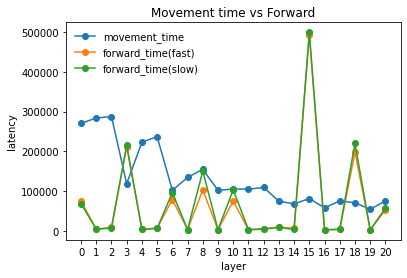

In [155]:
import matplotlib.pyplot as plt

delay_data = list(range(len(delay_data)))

plt.plot(delay_data, movement_time[:-1], label='movement_time', marker='o')
plt.plot(delay_data, AlexNet[1][fast], label='forward_time(fast)', marker='o')
plt.plot(delay_data, AlexNet[1][slow], label='forward_time(slow)', marker='o')
plt.title('Movement time vs Forward')
plt.xlabel('layer')
plt.ylabel('latency')
plt.xticks(delay_data)
plt.legend(frameon=False)
plt.show()

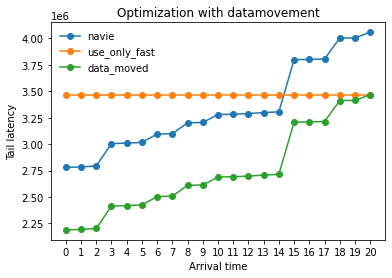

In [150]:
import matplotlib.pyplot as plt

delay_data = list(range(len(delay_data)))

plt.plot(delay_data, naive_data, label='navie', marker='o')
plt.plot(delay_data, use_only_fast_data, label='use_only_fast', marker='o')
plt.plot(delay_data, data_moved_data, label='data_moved', marker='o')
plt.title('Optimization with datamovement')
plt.xlabel('Arrival time')
plt.ylabel('Tail latency')
plt.xticks(delay_data)
plt.legend(frameon=False)
plt.show()